In [1]:
import os 
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from matplotlib import gridspec
import matplotlib.transforms as transforms
import seaborn as sns
import statsmodels.api as sm
from statsmodels.formula.api import ols
import scipy.stats as stats
from scipy.stats import mannwhitneyu
from scipy.stats import wilcoxon
import statsmodels.api as sm
import itertools
from sklearn.feature_selection import SelectKBest, f_classif
#from statannot import add_stat_annotation
import itertools
import scanpy as sc
import anndata as ad
import episcanpy.api as epi
from scipy.stats import ttest_ind, mannwhitneyu
%matplotlib inline

In [2]:
model_path = "../../cellformer/"
data = "../../data/adata_peak_matrix.h5ad"
annot_key="nearestGeneChip"
comparison="label"
pairs = [("NC", "RAD"), ("NC", "ADD"), ("RAD", "ADD")]
if not os.path.exists(model_path):
        os.mkdir(model_path)
savepath = model_path + comparison+ "/"
if not os.path.exists(savepath):
    os.mkdir(savepath)

In [3]:
adata = ad.read_h5ad(data)

adata = adata[adata.obs[comparison] != "Na"]
adata.obs[comparison].unique()
pseudosc = adata[adata.obs.label.isin(["ADD", "NC", "RAD"])]
epi.pp.lazy(pseudosc)

In [4]:
adata.obs

,celltype,replicate,brain_region,condition,sex,batch,expired_age,xxx.CognitiveStatus,Rep,PatientID,...,xxx.calc_B,xxx.C,xxx.calc_A,xxx.AP_freshBrainWeight,xxx.calc_thalPhase,xxx.GE_atherosclerosis_ID,xxx.micro_AmyloidAngiopathyOccipitalLobe_ID,binarize_braak,label,label_cerad
2,AST,1,CAUD,CTRL,Female,AD_X009,79.0,No dementia,T1,06_1516,...,1.0,0.0,-99.0,1120.0,Missing/unknown,3.0,1.0,1,NC,NC
3,AST,2,CAUD,CTRL,Female,AD_X009,79.0,No dementia,T2,06_1516,...,1.0,0.0,-99.0,1120.0,Missing/unknown,3.0,1.0,1,NC,NC
4,AST,1,CAUD,CTRH,Female,AD_X015,86.0,No dementia,T1,07_1144,...,2.0,2.0,-99.0,1045.0,Missing/unknown,3.0,2.0,0,RAD,RAD
5,AST,2,CAUD,CTRH,Female,AD_X015,86.0,No dementia,T2,07_1144,...,2.0,2.0,-99.0,1045.0,Missing/unknown,3.0,2.0,0,RAD,RAD
6,AST,1,CAUD,CTRH,Female,AD_X016,92.0,No dementia,T1,07_1287,...,2.0,2.0,-99.0,1180.0,Missing/unknown,2.0,2.0,0,RAD,RAD
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1771,OLD,2,HIPP,LOAD,Male,AD_X003,62.0,Dementia,T2,12_1181,...,3.0,3.0,3.0,1450.0,5 (A3),2.0,1.0,0,ADD,ADD
1772,OLD,1,HIPP,LOAD,Male,AD_X005,77.0,Dementia,T1,13_0855,...,3.0,3.0,2.0,1200.0,3 (A2),3.0,1.0,0,ADD,ADD
1773,OLD,2,HIPP,LOAD,Male,AD_X005,77.0,Dementia,T2,13_0855,...,3.0,3.0,2.0,1200.0,3 (A2),3.0,1.0,0,ADD,ADD
1774,OLD,1,HIPP,LOAD,Male,AD_X004,94.0,Dementia,T1,13_1300,...,3.0,3.0,3.0,1260.0,5 (A3),3.0,2.0,0,ADD,ADD


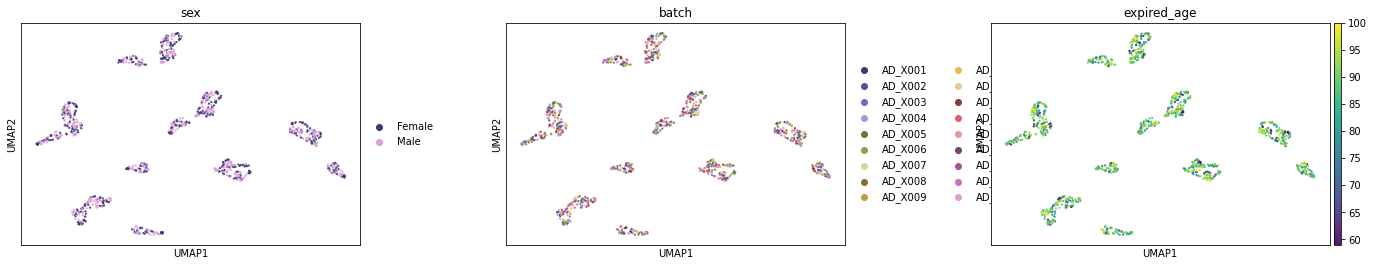

In [5]:
colors_ct={"Neur":"#75485E","EXC":"#C23E7E", "INH":"#75485E", "Glials":"#51A3A3","AST-OPCs-OLD":"#51A3A3", "OPCs-Oligo":"#51A3A3","OLD":"#51A3A3","OPCs":"#C0F0F0", "MIC":"#CB904D", "AST":"#C3E991",
           "bulk":"#cccccc", "CTRH":"#B6F2EC", "SPOR":"#F7D7C8","CAUD" :[18/255.,50/255.,59/255., 0.5],
                     "SMTG":[118/255.,14/255.,63/255.,0.5],
                     "PARL":[92/255.,64/255.,77/255.,0.5],
                     "HIPP" : [255/255., 192/255.,0, 0.5], "NC":"#28A89C", "ADD":"#F57764", "LOPD":"#F57764", "RAD":"#B6F2EC", "SPOR":"#F7D7C8", "ADAD":"#A84434"} 
sc._settings.ScanpyConfig.figdir = model_path 

sc.pl.umap(pseudosc, color=["sex", "batch","expired_age"], wspace=0.3,alpha=0.9, s=20, save= "pseudo_sc_analysis_umap_confounders.svg", palette="tab20b")#,palette=colors_ct,

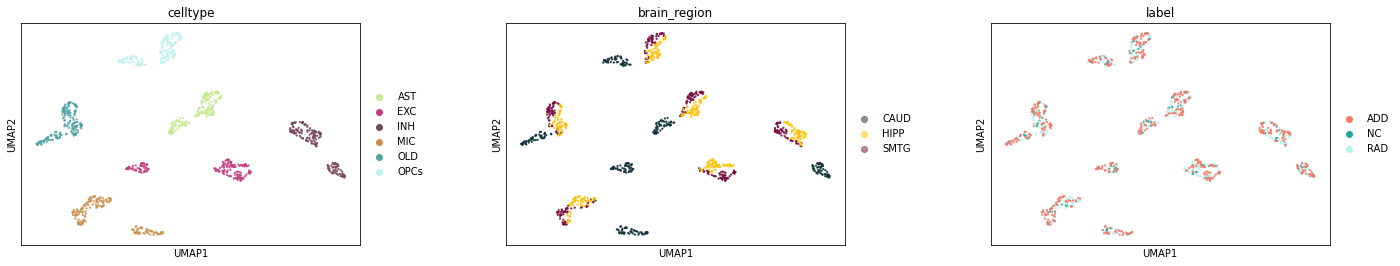

In [6]:
sc.pl.umap(pseudosc, color=["celltype", "brain_region","label"], wspace=0.3,alpha=0.9, s=20, save= "pseudo_sc_analysis_umap_.svg", palette=colors_ct)